# Variational Inference

Given observed data $\mathbf{x}$ and latent variables $\mathbf{z}$ ($\mathbf{z}$ can be some model parameter), we are interested in approximating the posterior $p(\mathbf{z}|\mathbf{x})$ using a surrogate function $q(\mathbf{z})$ that is almost as good. Assume $\mathbf{z} \sim p(\mathbf{z})$ is the prior. 
 
**Aim**: minimize the KL-divergence $KL[q(\mathbf{z}) || p(\mathbf{z}|\mathbf{x})] = E_{q}[\log\frac{q(\mathbf{z})}{p(\mathbf{z}|\mathbf{x})}]$

Since we don't know the posterior, derive

$
\begin{align*}
KL[q(\mathbf{z}) || p(\mathbf{z}|\mathbf{x})] &= E_{q}[\log\frac{q(\mathbf{z})}{p(\mathbf{z}|\mathbf{x})}] = E_{q}[\log\frac{q(\mathbf{z})p(\mathbf{x})}{p(\mathbf{z},\mathbf{x})}] \\
&= \underbrace{E_{q}[\log\frac{q(\mathbf{z})}{p(\mathbf{z},\mathbf{x})}]}_{-ELBO} + \underbrace{\log p(\mathbf{x})}_{\text{evidence (fixed)}}
\end{align*}
$

Then we have $\min_{q} KL = \max_q ELBO$

Note that since $KL[q(\mathbf{z}) || p(\mathbf{z}|\mathbf{x})] \ge 0$, 
we have $\log p(\mathbf{x}) \ge ELBO = E_{q}[\log\frac{q(\mathbf{z})}{p(\mathbf{z},\mathbf{x})}]$, which is the same as the derivation from Jenson's inequality. Or, from the reverse approach, we can get KL-divergence non-negative from the inequality. 

## References of Variational Inference

* https://arxiv.org/abs/1601.00670

* https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf

* https://www.youtube.com/watch?v=HxQ94L8n0vU&t=474s


# Report on previous comments

This section summarizes some key points from the comments from Professor Scott Schwartz about variational inference https://github.com/pointOfive/Haining-Tan/blob/main/MADE_comments.ipynb

## Set up

Model: A simple linear regression $y \sim N(\beta_0 + \beta_1x, \sigma^2)$

Model parameter: ${\theta} = (\beta_0, \beta_1) \sim p(\theta)$ prior

Variational inference on the model parameter:

$
\begin{align*}
\underbrace{\log p(y)}_{\text{Fixed marginal}} = E_q[\log p(y|\theta)] + \underbrace{E_q [\log\frac{q(\theta)}{p(\theta|y)}]}_{KL[q || p(\theta|y)]} - \underbrace{E_q[\log \frac{q(\theta)}{p(\theta)}]}_{KL[q || p(\theta)]}
\end{align*}
$

where $q(\theta)$ is the surrogate posterior used to approximate the true posterior $p(\theta|y)$

I can see the trade-off between the three terms, but I am not sure about the second point. I think you mean the correction between the posterior and the prior, but I did not get the equation here. 

>2. a correction factor for wrongly integrating over $q(\theta) \approx p(\theta|y) \not = p(\theta)$
  - since $\log p(y) = E_{p(\theta)}[\log p(y|\theta)] \not =  E_{p(\theta|y)}[\log p(y|\theta)].$

## Implementation of DenseVariational Layer

DenseVariational Layer in TFP approximates the posteror by minimizing the KL-divergence based on the variational inference equation above:

$$KL[q|| p(\theta|y)] = \log p(y) + E_q[\log \frac{q(\theta)}{p(\theta)}] - E_q[\log p(y|\theta)]$$

where the objective is $\min_q E_q[\log \frac{q(\theta)}{p(\theta)}] - E_q[\log p(y|\theta)]$

* In my understanding, after approximating the posterior distribution for the model parameter $\theta = (\beta_0, \beta_1)$, DenseVariational Layer draws and returns a distribution $N(\hat\beta_0 + \hat\beta_1x, \sigma^2)$ from the posterior of $\beta_0, \beta_1$

* TODO: loss calculation, really struggling here... Not quite see your point addressing the model.losses... 

* kl-weight should be averaged by the batch size since the kl-divergence is calculated by batch. 

# Gaussian Process

## Set up

* Given a set $S$, a Gaussian process is a random variable collection $\{X_s|s\in S\}$. It is a generalization of multivariate Gaussian distribution.

* Property: Let $\{s_1, s_2, ..., s_n\} \subset S$ be an arbitrary finite subset of $S$, let $\{X_{s_1}, X_{s_2},... X_{s_n}\}$ be a finite set of random variables indexed by $S$, then they follow multivariate Gaussian. 

* Can choose covariance/kernel function, only need to be symetric and positive-definite.


## Gaussian Process regression

Given input $x_1,...,x_n$ and observations $y_1,...,y_n$, we are interested in estimating an unknown smooth relationship $y = f(x) + \epsilon$, where $\epsilon$ is a noise term. 

Model: 
* $f \sim$ GaussianProcess($\mu$, $K$), where $\mu:S\rightarrow R$ is the mean function and $K:S\times S\rightarrow R$ is the covariance/kernel function

* $y_i \sim  N(f(x_i), \sigma^2), i=1,...,n$


Let $\boldsymbol{\mu} = [\mu(x_1), ...,\mu(x_n)]$ and $
\mathbf{K} = 
\begin{bmatrix}
k(x_1,x_1) & \dots & k(x_1,x_n)\\
\vdots & \ddots & \vdots\\
k(x_n, x_1) & \dots & k(x_n, x_n)\\
\end{bmatrix}
$

we have $(f(x_1), ..., f(x_n)) \sim \text{MultiGaussian}(\boldsymbol{\mu}, \mathbf{K})$

TODO: More details on GP posterior

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

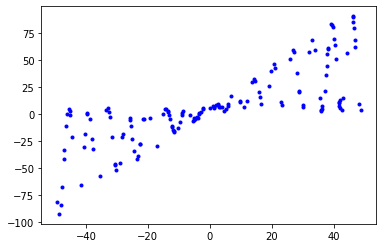

In [2]:
k = 1
b = 5
x_min = -50
x_max = 50

n = 150

def aleatoric(x): # variablity function for a particular x
  r = (x - x_min) / (x_max - x_min)
  return 2 * r

def generate_data(n):
  x = (x_max - x_min) * np.random.rand(n) + x_min 
  noise = np.random.randn(n) * aleatoric(x)
  y = (k * x * (1 + np.sin(x)) + b) + noise   # add some non-linearity and noise
  x = x[..., np.newaxis] # convert to N * 1 matrix
  return x, y

x_train, y_train = generate_data(n)
x_test, y_test = generate_data(n)

plt.figure()
plt.plot(x_train, y_train, "b.")

### Build an exponential quadratic kernel

$$K(x_1, x_2) =  \sigma^2 \exp(\frac{||x_1 - x_2||^2}{\lambda^2})$$

where $\sigma$ is the amplitude and $\lambda$ is the length scale.

In [4]:
# Kernel function

# "should be a tf.keras.Layer with an @property 
# that late-binds variable parameters to a 
# tfp.positive_semidefinite_kernel.PositiveSemidefiniteKernel instance"

class kernel_fn(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(kernel_fn, self).__init__(**kwargs)
    dtype = kwargs.get('dtype', None)
    self._amplitude = self.add_variable(
        initializer=tf.constant_initializer(0), dtype=dtype, name="a"
    )
    self._length_scale = self.add_variable(
        initializer=tf.constant_initializer(0), dtype=dtype, name="scale"
    )
  def call(self, x): # will not be used
    return x 
  @property
  def kernel(self):
    return tfp.math.psd_kernels.ExponentiatedQuadratic(
        amplitude=tf.nn.softplus(self._amplitude),
        length_scale=tf.nn.softplus(self._length_scale)
    )

### Build the GP model

In [5]:
# For stability
# tf.keras.backend.set_floatx('float64')

model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=[1]),
  tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False),
  tfp.layers.VariationalGaussianProcess(
      num_inducing_points=40,
      kernel_provider=kernel_fn(),
      event_shape=[1],
      inducing_index_points_initializer=tf.constant_initializer(
          np.linspace(-50, 50, num=40, dtype=x_train.dtype)[..., np.newaxis]
      ),
      unconstrained_observation_noise_variance_initializer=(
          tf.constant_initializer(np.array(0.54).astype(x_train.dtype))
      )
  )
])


Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/distributions/gaussian_process.py:364: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


There are a faw warnings, I am not familar with the up to date implementation...



In [6]:
# loss function for GP inference
def loss(y, f):
  return f.variational_loss(y, kl_weight=np.array(32, x_train.dtype)/x_train.shape[0])

# train the model
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
model.fit(x_train, y_train, epochs=1000, verbose=False)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/distributions/gaussian_process.py:364: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


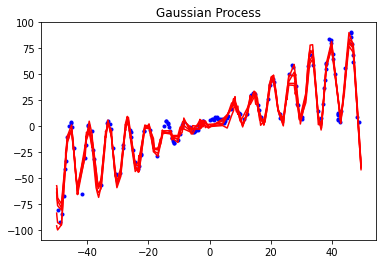

In [32]:
x_test = np.sort(x_test)
gp = model(x_test)
plt.figure()
plt.plot(x_train, y_train, "b.")
for i in range(5):
  sample = gp.sample().numpy()
  f = sample[..., 0]
  plt.plot(x_test[..., 0], f, 'r')
plt.title("Gaussian Process")
plt.show()

## References of Gaussian Process

* https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html

* https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP

* http://www.gaussianprocess.org/gpml/

* https://www.youtube.com/watch?v=4vGiHC35j9s

